<a href="https://colab.research.google.com/github/bitnurihan/Capstone_Project_Starbucks/blob/master/Analysing_starbucks_location_Seoul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
import json
import pandas as pd

# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "6e19a90f-971c-46b3-852c-0c48c436d1fc"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())
print(package["result"])

# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] }
        r = urllib.request.urlopen(url, data=bytes(json.dumps(p), encoding="utf-8"))
        data = json.loads(r.read())
        df = pd.DataFrame(data["result"]["records"])
        break
df

{'license_title': 'Open Government Licence – Toronto', 'owner_unit': None, 'relationships_as_object': [], 'topics': 'City government,Community services,Locations and mapping', 'owner_email': 'opendata@toronto.ca', 'excerpt': 'The Neighbourhood Profiles provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighbourhood. The data is based on tabulations of 2016 Census of Population data from Statistics Canada.', 'private': False, 'owner_division': 'Social Development, Finance & Administration', 'num_tags': 15, 'id': '6e19a90f-971c-46b3-852c-0c48c436d1fc', 'metadata_created': '2019-07-23T17:47:12.629378', 'refresh_rate': 'As available', 'title': 'Neighbourhood Profiles', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': 'https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/', 'license_id': 'open-government-licence-toronto', 'type': 'da

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,...,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,n/a,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,...,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,n/a,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,...,NIA,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,NIA,NIA,NIA,No Designation,No Designation,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,NIA,NIA,No Designation,No Designation,NIA,No Designation,NIA,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695","15,873","25,797","21,396","13,154","23,236","6,577","29,960","22,291","21,737","7,727","14,257","9,266","11,499","17,757","11,669","9,955","10,968","13,362","31,340","26,984","16,472","15,935","14,133","9,666","17,180","27,051","25,003","36,625","35,052",...,"10,803","10,529","22,246","14,974","20,923","46,496","10,070","9,941","16,724","21,849","27,876","17,812","24,623","25,051","27,446","15,683","21,567","10,360","21,108","16,556","7,607","17,510","65,913","27,392","33,312","26,274","17,992","11,098","27,917","50,434","16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918","15,434","19,348","17,671","13,530","23,185","6,488","27,876","21,856","22,057","7,763","14,302","8,713","11,563","17,787","12,053","9,851","10,487","13,093","28,349","24,770","14,612","15,703","13,743","9,444","16,712","26,739","24,363","34,631","34,659",...,"10,007","10,488","22,267","15,050","20,631","45,912"

In [0]:
import warnings
warnings.filterwarnings('ignore')
# warning 메시지 제거, warning 메시지는 라이브러리 업데이트나 사용법에 대한 안내 등이 있습니다.
# 코딩을 처음 시작할 때는  warning 메시지가 나오면 당황하실 수도 있어서 제거를 하고 보도록 합니다.
# warning 메시지는 제거하고 보셔도 되지만 Error 메시지를 꼭 고쳐주셔야 합니다.
warnings.filterwarnings('ignore', 'This pattern has match groups')
warnings.filterwarnings('ignore', 'The iterable function was deprecated in Matplotlib')

In [0]:
import pandas as pd
import numpy as np
# 기존 plotnine(ggplot)코드를 pandas와 seaborn으로 변경
# from plotnine import *
import seaborn as sns
# 지도 시각화를 위해
import folium

# 노트북 안에서 그래프를 표시하기 위해
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# Mac 의 한글 폰트 설정
plt.rc('font', family='AppleGothic') 
plt.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')

In [50]:
shop_2019 = pd.read_csv('store_seoul_201912_01.csv', encoding='utf-8', sep='|')
shop_2019.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,19905471,와라와라호프,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,기타 주점업,11,서울특별시,11680,강남구,1168060000,대치1동,1168010600,대치동,1168010600206040000,1,대지,604,NaN,서울특별시 강남구 대치동 604,116802000003,서울특별시 강남구 남부순환로,2933,NaN,1168010600106040000014378,대치상가,서울특별시 강남구 남부순환로 2933,135280,6280.0,NaN,1,NaN,127.061026,37.493922
1,19911397,커피빈코리아선릉로93길점,코리아선릉로93길점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11680,강남구,1168064000,역삼1동,1168010100,역삼동,1168010100206960042,1,대지,696,42.0,서울특별시 강남구 역삼동 696-42,116804166502,서울특별시 강남구 선릉로93길,6,NaN,1168010100106960042022041,NaN,서울특별시 강남구 선릉로93길 6,135080,6149.0,NaN,1,NaN,127.047883,37.505675
2,19911801,프로포즈,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,기타 주점업,11,서울특별시,11545,금천구,1154563000,독산3동,1154510200,독산동,1154510200201620001,1,대지,162,1.0,서울특별시 금천구 독산동 162-1,115453117003,서울특별시 금천구 가산로,34,6.0,1154510200101620001017748,NaN,서울특별시 금천구 가산로 34-6,153010,8545.0,NaN,1,NaN,126.899220,37.471711
3,19912201,싱싱커피&토스트,NaN,Q,음식,Q07,패스트푸드,Q07A10,토스트전문,I56192,"피자, 햄버거, 샌드위치 및 유사 음식점업",26,부산광역시,26530,사상구,2653062000,괘법동,2653010400,괘법동,2653010400205780000,1,대지,578,NaN,부산광역시 사상구 괘법동 578,265303139004,부산광역시 사상구 괘감로,37,NaN,2653010400105780000002037,산업용품유통상가,부산광역시 사상구 괘감로 37,617726,46977.0,NaN,1,26,128.980455,35.159774
4,19932756,가락사우나내스낵,NaN,F,생활서비스,F09,대중목욕탕/휴게,F09A02,사우나/증기탕/온천,S96121,욕탕업,11,서울특별시,11710,송파구,1171060000,석촌동,1171010500,석촌동,1171010500202560000,1,대지,256,NaN,서울특별시 송파구 석촌동 256,117103123001,서울특별시 송파구 가락로,71,NaN,1171010500102560005010490,NaN,서울특별시 송파구 가락로 71,138846,5690.0,NaN,1,NaN,127.104071,37.500249


In [51]:
df_seoul = shop_2019.loc[shop_2019['시도명'].str.startswith('서울')].copy()
df_seoul.shape

(407376, 39)

In [52]:
df_starbucks = df_seoul[df_seoul['상호명'].str.contains('스타벅스|starbucks|STARBUCKS')]
df_starbucks.shape
df_starbucks['상호명'] = 'starbucks'
df_starbucks.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
1104,19976038,starbucks,이태원점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11170,용산구,1117065000,이태원1동,1117013000,이태원동,1117013000201270006,1,대지,127,6.0,서울특별시 용산구 이태원동 127-6,111703102009,서울특별시 용산구 이태원로,188,NaN,1117013000101270029009542,NaN,서울특별시 용산구 이태원로 188,140200,4406.0,NaN,NaN,29,126.994781,37.534303
2023,19998811,starbucks,종로3가점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11110,종로구,1111061500,종로1.2.3.4가동,1111015600,종로3가,1111015600200090003,1,대지,9,3.0,서울특별시 종로구 종로3가 9-3,111103100013,서울특별시 종로구 종로,113,1.0,1111015600100090003016323,NaN,서울특별시 종로구 종로 113-1,110123,3139.0,NaN,1,NaN,126.990207,37.570585
2770,20680373,starbucks,신사2점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11650,서초구,1165054000,잠원동,1165010600,잠원동,1165010600200280001,1,대지,28,1.0,서울특별시 서초구 잠원동 28-1,116502102001,서울특별시 서초구 강남대로,581,NaN,1165010600100280001019301,푸른빌딩,서울특별시 서초구 강남대로 581,137904,6530.0,NaN,2,NaN,127.019763,37.513663
14770,20283351,starbucks,NaN,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11560,영등포구,1156054000,여의동,1156011000,여의도동,1156011000200230000,1,대지,23,NaN,서울특별시 영등포구 여의도동 23,115603118002,서울특별시 영등포구 국제금융로,10,NaN,1156011000100230000000001,서울국제금융센터,서울특별시 영등포구 국제금융로 10,150945,7326.0,NaN,3,NaN,126.924863,37.525172
14781,20288646,starbucks,삼성역점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11680,강남구,1168058000,삼성1동,1168010500,삼성동,1168010500201680026,1,대지,168,26.0,서울특별시 강남구 삼성동 168-26,116804166710,서울특별시 강남구 테헤란로103길,9,NaN,1168010500101680026016641,제일빌딩,서울특별시 강남구 테헤란로103길 9,135090,6173.0,NaN,1,NaN,127.063878,37.510038


In [139]:
geo_df = df_starbucks
df_starbucks_brand = pd.DataFrame(
    df_starbucks.groupby(['시군구명'])['상호명'].count()
)
df_starbucks_brand.columns = ['the number of stores']
df_starbucks_brand.head()

,the number of stores
시군구명,
강남구,84
강동구,13
강북구,5
강서구,17
관악구,11


In [0]:
import json

state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

In [84]:
map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
                 zoom_start=11)

map.choropleth(geo_data = state_geo,
               data = df_starbucks_brand['the number of stores'],
               columns = [df_starbucks_brand.index, df_starbucks_brand['the number of stores']],
               fill_color = 'Purples',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)


for n in geo_df.index:
    # popup text setting
    popup_name = geo_df.loc[n, '상호명'] + ' - ' + geo_df.loc[n, '도로명주소']
    folium.CircleMarker(
            location=[geo_df.loc[n,'위도'], geo_df.loc[n, '경도']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(map)
map

In [136]:
seoul_df = pd.read_excel('seoul_income.xlsx', skiprows = 13, index_col=0)
seoul_income_df = seoul_df.iloc[:25,:3]
seoul_income_df.columns = ['eng name','the number of employee', 'average annual income']
seoul_income_df['average annual income'] = round(seoul_income_df['average annual income'] * 1000000 / seoul_income_df['the number of employee'],0)
seoul_income_df.head()

,eng name,the number of employee,average annual income
서울,,,
강남구,Gangnam-gu,206821.0,69642773
강동구,Gangdong-gu,165248.0,38071813
강북구,Gangbuk-gu,103391.0,28179687
강서구,Gangseo-gu,242516.0,36323785
관악구,Gwanak-gu,212016.0,30757580


In [140]:
income_map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
                 zoom_start=11)

income_map.choropleth(geo_data = state_geo,
               data = seoul_income_df['average annual income'],
               columns = [seoul_income_df.index, seoul_income_df['average annual income']],
               fill_color = 'Purples',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)
for n in geo_df.index:
    # popup text setting
    popup_name = geo_df.loc[n, '상호명'] + ' - ' + geo_df.loc[n, '도로명주소']
    folium.CircleMarker(
            location=[geo_df.loc[n,'위도'], geo_df.loc[n, '경도']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(income_map)
        
income_map

In [137]:
employee_df = pd.read_excel('seoul_employee.xlsx', skiprows = 13, index_col=0)
seoul_employee_df = employee_df.iloc[:25,:2]
seoul_employee_df.columns = ['eng name','the number of employee']
seoul_employee_df.head()

,eng name,the number of employee
서울,,
강남구,Gangnam-gu,955553.0
강동구,Gangdong-gu,111424.0
강북구,Gangbuk-gu,40465.0
강서구,Gangseo-gu,221810.0
관악구,Gwanak-gu,74556.0


In [149]:
employee_map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
                 zoom_start=11)

employee_map.choropleth(geo_data = state_geo,
               data = seoul_employee_df['the number of employee'],
               columns = [seoul_employee_df.index, seoul_employee_df['the number of employee']],
               fill_color = 'Purples',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)
for n in geo_df.index:
    # popup text setting
    popup_name = geo_df.loc[n, '상호명'] + ' - ' + geo_df.loc[n, '도로명주소']
    folium.CircleMarker(
            location=[geo_df.loc[n,'위도'], geo_df.loc[n, '경도']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(employee_map)
employee_map

In [170]:
seoul_population = pd.read_csv('seoul_population.csv', index_col=0)
seoul_population.head()

,Total population,Household,Men,Women
행정구역,,,,
강남구,546436,233849,261466,284970
강동구,446887,187626,220464,226423
강북구,313289,144553,152857,160432
강서구,590419,263413,285619,304800
관악구,499587,269964,250822,248765


In [177]:
seoul_full_df = pd.concat([seoul_employee_df['eng name'],seoul_population['Total population'],seoul_employee_df['the number of employee'], seoul_income_df['average annual income'], df_starbucks_brand['the number of stores']], axis=1)

seoul_full_df.head()

,eng name,Total population,the number of employee,average annual income,the number of stores
강남구,Gangnam-gu,546436,955553.0,69642773,84
강동구,Gangdong-gu,446887,111424.0,38071813,13
강북구,Gangbuk-gu,313289,40465.0,28179687,5
강서구,Gangseo-gu,590419,221810.0,36323785,17
관악구,Gwanak-gu,499587,74556.0,30757580,11


In [0]:
def heatMap(df, mirror):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(10, 10))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

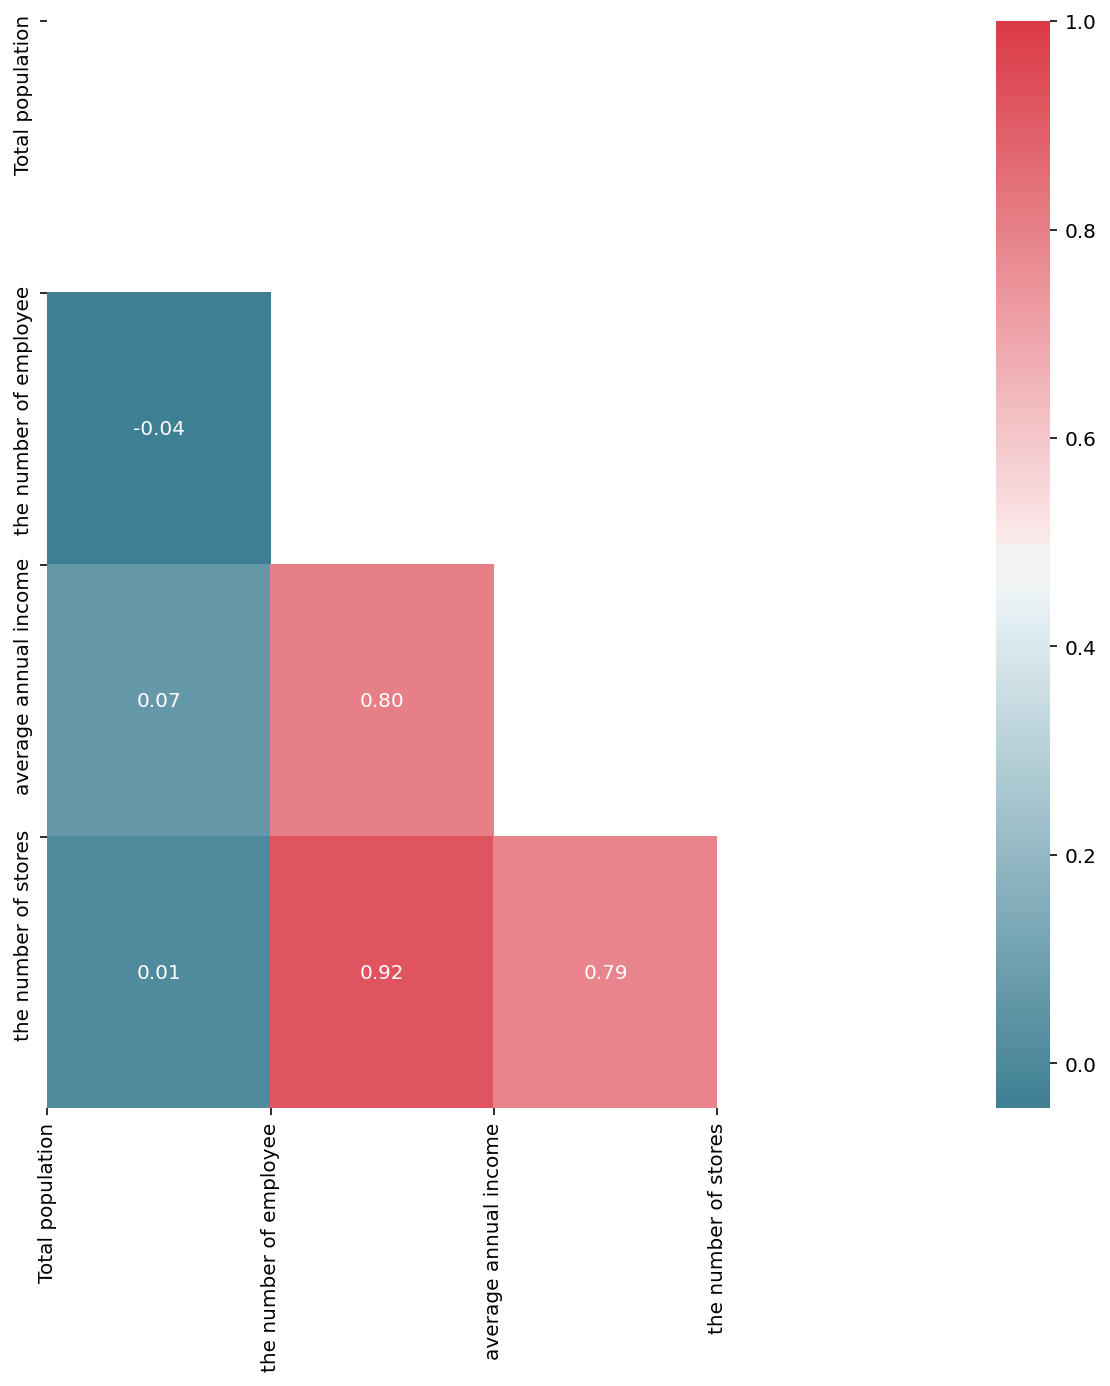

In [175]:
heatMap(seoul_full_df, mirror=False)

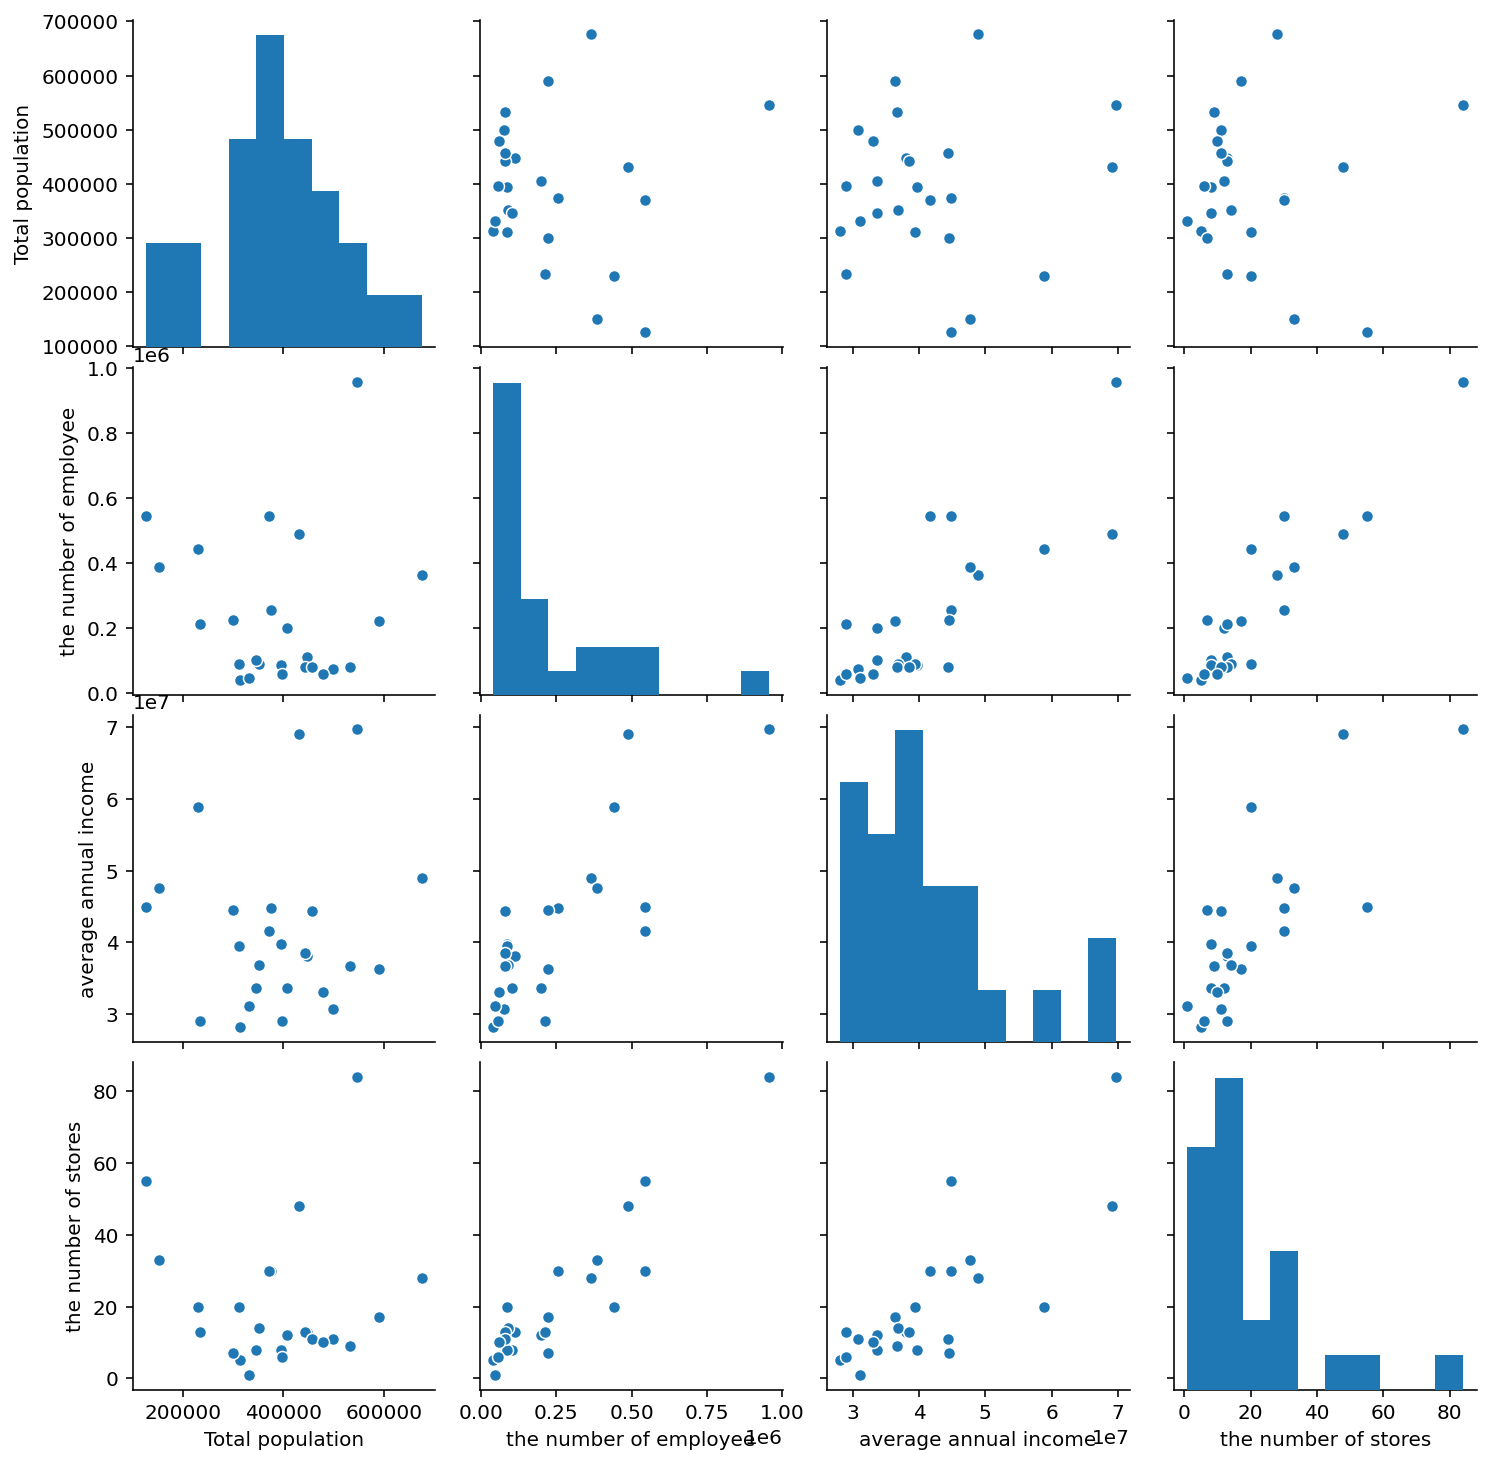

In [176]:
sns.pairplot(seoul_full_df)